# DASK INTRO

Dask has support for parallelizing NumPy, Pandas, and Scikit-Learn. It is a great tool for parallelizing your code and speeding up your computations.

In [2]:
import numpy as np
import dask
import dask.array as da

# import dask.bag as db
# import dask.dataframe as dd

Dask has submodules for parallelizing different libraries. For example, Dask-Array is for parallelizing NumPy, Dask-DataFrame is for parallelizing Pandas, and Dask-ML is for parallelizing Scikit-Learn. Dask-bag is for unstructured data, and dask-delayed is for parallelizing custom code. Dask-array is the one we will be using for now.

Dask-array can use most of the NumPy functions and methods. It can also use the same indexing and slicing as NumPy. One difference is that dask-arrays are stored in chunks, meaning that the array is divided into smaller blocks or arrays. This is useful for parallelizing your code. The following shows 2 ways of creating a dask-array. In the first example, we create a dask-array from a NumPy array and set blocks of 100 by 100. In the second example, we create a dask-array from a dask-array and in this case, our chunks are aligned with one of the axes.

In [3]:
data = np.arange(100_000).reshape(200, 500)
a = da.from_array(data, chunks=(100, 100))
# a = da.arange(100_000, chunks=10000).reshape(200, 500, merge_chunks=False)
a

dask.array<array, shape=(200, 500), dtype=int32, chunksize=(100, 100), chunktype=numpy.ndarray>

We can inspect the chunks of a dask-array by using the .chunks attribute. This will return a tuple with the chunks of the dask-array. We can also index the blocks of a dask-array by using the .blocks attribute.

In [6]:
# inspect the chunks
print(f'{a.chunks = }')

# access a particular block of data
a.blocks[1, 3]

a.chunks = ((100, 100), (100, 100, 100, 100, 100))


dask.array<blocks, shape=(100, 100), dtype=int32, chunksize=(100, 100), chunktype=numpy.ndarray>

Another useful property for parallelization is that Dask-arrays are lazy, meaning that they do not compute the result until you ask for it. In the following example, we print the created array and this only retruns the dask array object. In the next cell we do some operations on the array. The results of these are not computed until we ask for it. We can ask for the result entries by using the .compute() method.

In [7]:
print(f'{a[:50, 200] = }')
a[:50, 200].compute()

a[:50, 200] = dask.array<getitem, shape=(50,), dtype=int32, chunksize=(50,), chunktype=numpy.ndarray>


array([  200,   700,  1200,  1700,  2200,  2700,  3200,  3700,  4200,
        4700,  5200,  5700,  6200,  6700,  7200,  7700,  8200,  8700,
        9200,  9700, 10200, 10700, 11200, 11700, 12200, 12700, 13200,
       13700, 14200, 14700, 15200, 15700, 16200, 16700, 17200, 17700,
       18200, 18700, 19200, 19700, 20200, 20700, 21200, 21700, 22200,
       22700, 23200, 23700, 24200, 24700])

In [8]:
print(f"{a.mean() = }")
a.mean().compute()

# np.sin(a)
# np.sin(a).compute()

# a.T
# a.T.compute()

a.mean() = dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=(), chunktype=numpy.ndarray>


49999.5

All of the large-scale Dask collections like Dask Array, Dask DataFrame, and Dask Bag and the fine-grained APIs like delayed and futures generate task graphs where each node in the graph is a normal Python function and edges between nodes are normal Python objects that are created by one task as outputs and used as inputs in another task. We can use the .visualize() method to see the graph of the operations even before we call compute to execute them. This is useful for debugging and understanding the parallelization of your code. Below is an example of a simple graph of operations.

b = dask.array<add, shape=(200,), dtype=int32, chunksize=(100,), chunktype=numpy.ndarray>


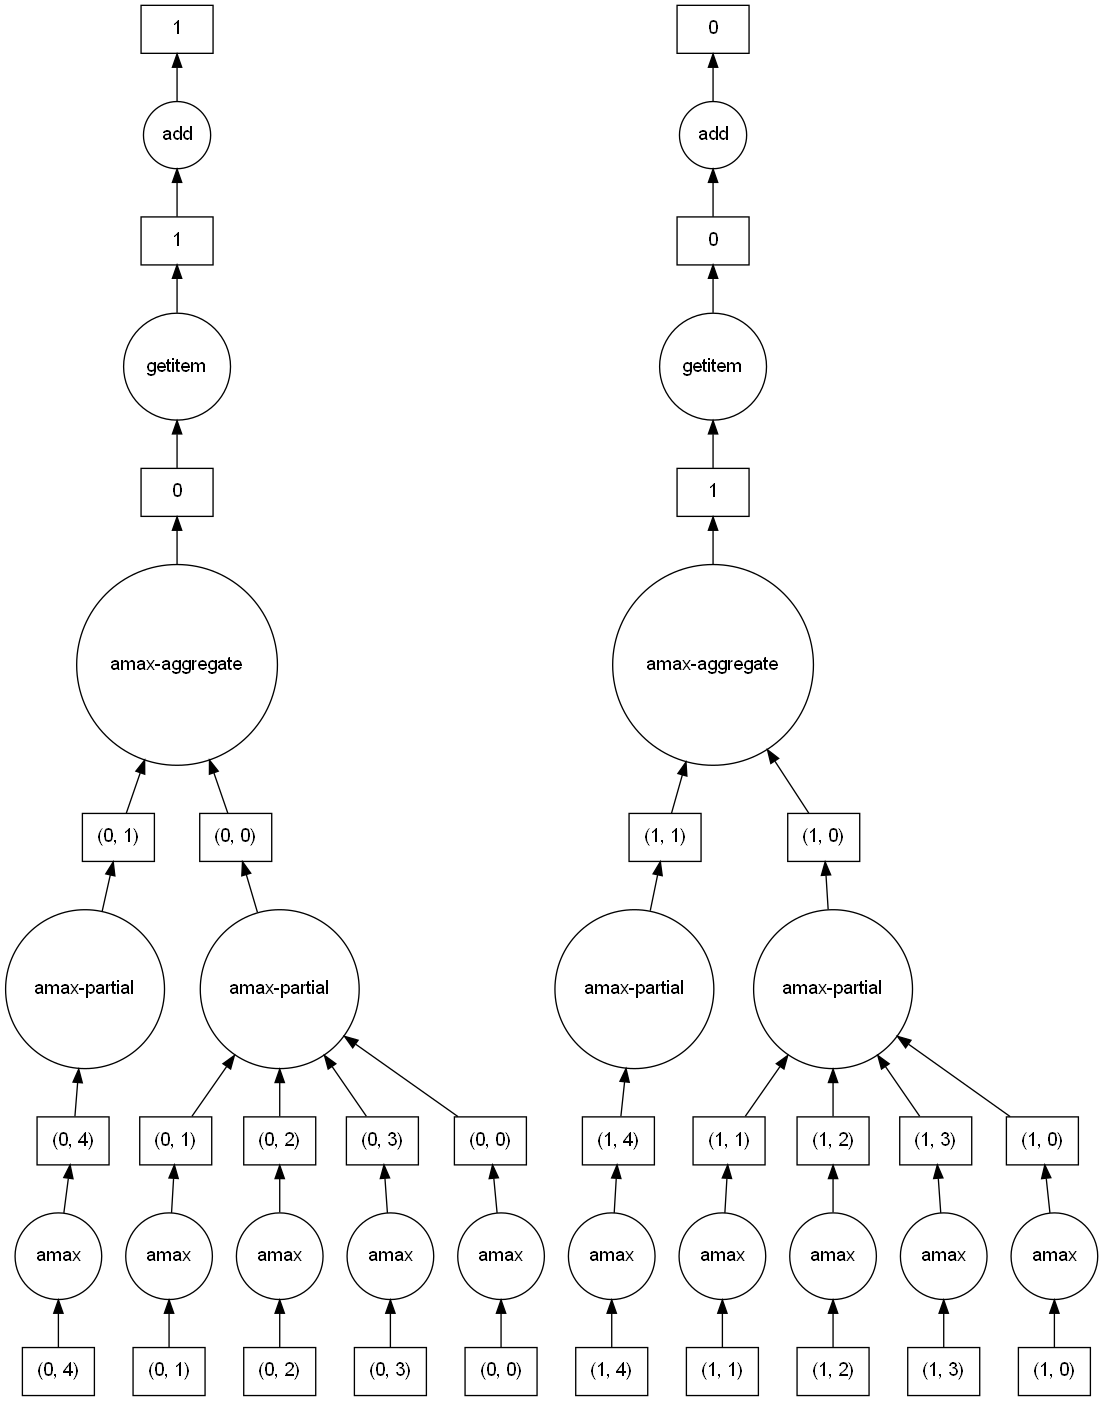

In [9]:
b = a.max(axis=1)[::-1] + 10
print(f'{b = }')

# b.dask
b.visualize()

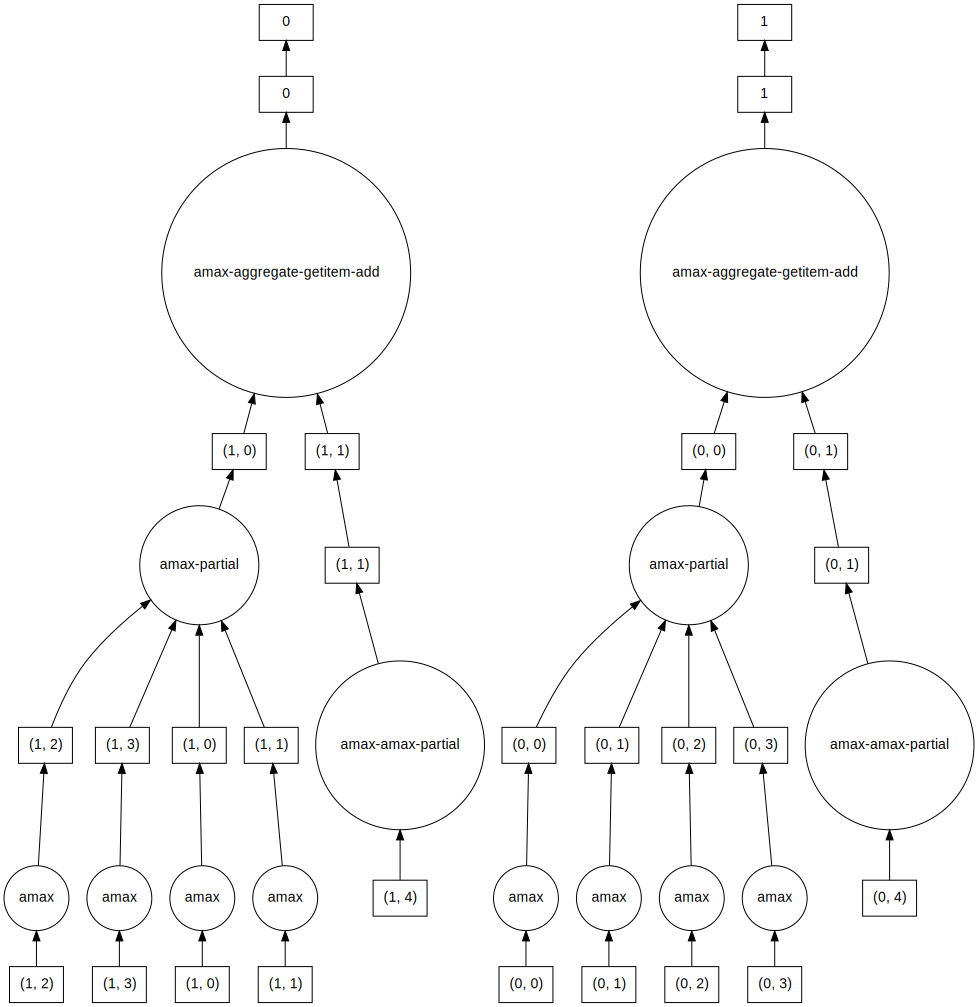

In [41]:
# We could also save the graph to a file
b.visualize(filename='dask_graph.svg', optimize_graph=True)

# Scheduling

After Dask generates these task graphs, it needs to execute them on parallel hardware. This is the job of a *task scheduler*. Different task schedulers exist, and each will consume a task graph and compute the same result, but with different performance characteristics. By default, for the majority of Dask APIs, when you call compute on a Dask object, Dask uses the thread pool on your computer (a.k.a threaded scheduler) to run computations in parallel. This is true for Dask Array, Dask DataFrame, and Dask Delayed. The exception being Dask Bag which uses the multiprocessing scheduler by default.

Dask has two families of task schedulers:

- **Single-machine scheduler**: This scheduler provides basic features on a local process or thread pool. This scheduler was made first and is the default. It is simple and cheap to use, although it can only be used on a single machine and does not scale

- **Distributed scheduler**: This scheduler is more sophisticated, offers more features, but also requires a bit more effort to set up. It can run locally or distributed across a cluster

![Dask overview](https://docs.dask.org/en/latest/_images/dask-overview.svg)

If you want more control, use the distributed scheduler instead. Think of it as the “advanced scheduler”. The Dask distributed scheduler can either be setup on a cluster or run locally on a personal machine. Despite having the name “distributed”, it works well on both single and multiple machines and is often pragmatic on local machines for a few reasons:

1. It provides access to asynchronous API, notably Futures

2. It provides a diagnostic dashboard that can provide valuable insight on performance and progress

3. It handles data locality with more sophistication, and so can be more efficient than the multiprocessing scheduler on workloads that require multiple processes Below is an example of how to set up the distributed scheduler.

In [10]:
from dask.distributed import Client
client = Client()
client
# client.dashboard_link
# client.close()

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 12,Total memory: 15.82 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:56415,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 12
Started: Just now,Total memory: 15.82 GiB
Comm: tcp://127.0.0.1:56446,Total threads: 3
Dashboard: http://127.0.0.1:56447/status,Memory: 3.96 GiB
Nanny: tcp://127.0.0.1:56421,


Once the above code is ran, it replaces the default scheduler and every computation is ran with the client created. The client has a dashboard that can be used to monitor the progress of the computations. The dashboard can be accessed by going to the address that is printed when the client is created. The dashboard is useful for debugging and understanding the parallelization of your code.

# Configuration

You can configure the global default scheduler by using the dask.config.set(scheduler...) command. For example, we can set the number of workers, the number of threads per worker, the memory limit, and the number of retries for failed tasks. We can also set the scheduler to be synchronous, asynchronous, or adaptive. The single-threaded synchronous scheduler executes all computations in the local thread with no parallelism at all. This is particularly valuable for debugging and profiling, which are more difficult when using threads or processes. Configuration can be done globally:

In [12]:
x = da.arange(100, chunks=10)

# dask.config.set(scheduler='threads')
# dask.config.set(scheduler='synchronous')  # overwrite default with single-threaded scheduler
# dask.config.set(scheduler='single-threaded') # This computation runs serially instead of in parallel
# dask.config.set(num_workers=4)
dask.config.set(scheduler='processes')
x.sum().compute()

4950

or as a context manager:

In [13]:
# with dask.config.set(scheduler='threads'):
# with dask.config.set(scheduler='synchronous'):
# with dask.config.set(scheduler='single-threaded'):
# with dask.config.set(num_workers=4):
with dask.config.set(scheduler='processes'):
    x.sum().compute()

or within a single compute call:

In [15]:
# x.sum().compute(scheduler='threads')
# x.sum().compute(scheduler='synchronous')
# x.sum().compute(scheduler='single-threaded')
# x.sum().compute(scheduler='processes')
x.sum().compute(num_workers=4)
# x.compute(num_workers=4)

4950

Each scheduler may support extra keywords specific to that scheduler. For example, the pool-based single-machine scheduler allows you to provide custom pools or specify the desired number of workers:

In [16]:
from concurrent.futures import ThreadPoolExecutor
with dask.config.set(pool=ThreadPoolExecutor(4)):
    x.compute()

# Delayed: Lazy

Dask Delayed lets you to wrap individual function calls into a lazily constructed task graph:

In [17]:
import dask

@dask.delayed
def inc(x):
   return x + 1

@dask.delayed
def add(x, y):
   return x + y

a = inc(1)       # no work has happened yet
b = inc(2)       # no work has happened yet
c = add(a, b)    # no work has happened yet

c = c.compute()  # This triggers all of the above computations

# Futures: Immediate

Unlike the interfaces described so far, Futures are eager. Computation starts as soon as the function is submitted. Futures can only be used with distributed cluster. Below is an example of how to use futures.

In [18]:
from dask.distributed import Client

client = Client()

def inc(x):
   return x + 1

def add(x, y):
   return x + y

a = client.submit(inc, 1)     # work starts immediately
b = client.submit(inc, 2)     # work starts immediately
c = client.submit(add, a, b)  # work starts immediately

c = c.result()                # block until work finishes, then gather result

c:\Users\issah\anaconda3\lib\site-packages\distributed\node.py:179: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 56592 instead
  warnings.warn(


In [ ]:
client.close()

2024-02-19 21:34:13,776 - distributed.scheduler - WARNING - Worker failed to heartbeat within 300 seconds. Closing: <WorkerState 'tcp://127.0.0.1:56446', name: 0, status: running, memory: 0, processing: 0>
2024-02-19 21:34:13,805 - distributed.scheduler - WARNING - Worker failed to heartbeat within 300 seconds. Closing: <WorkerState 'tcp://127.0.0.1:56452', name: 1, status: running, memory: 0, processing: 0>
2024-02-19 21:34:13,814 - distributed.scheduler - WARNING - Received heartbeat from unregistered worker 'tcp://127.0.0.1:56452'.
2024-02-19 21:34:13,818 - distributed.scheduler - WARNING - Received heartbeat from unregistered worker 'tcp://127.0.0.1:56446'.
2024-02-19 21:34:15,155 - distributed.nanny - WARNING - Restarting worker
2024-02-19 21:34:15,172 - distributed.nanny - WARNING - Restarting worker
2024-02-19 23:11:07,378 - distributed.scheduler - WARNING - Worker failed to heartbeat within 300 seconds. Closing: <WorkerState 'tcp://127.0.0.1:56449', name: 3, status: running, me